# State Reducers 


## Goals

Now, we're going to dive into reducers, which specify how state updates are performed on specific keys / channels in the state schema.


### Default: overwriting state

By default, to update values when we pass through a node, the LangGraph overwrite the values. 

In [2]:
from typing_extensions import TypedDict
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

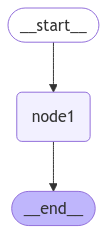

In [4]:
class State(TypedDict):
    x: int
        
def node1(state: State):
    print("---node 1---")
    return {'x': state['x'] * 2}

# Build graph
builder = StateGraph(State)
builder.add_node("node1", node1)

# Logic
builder.add_edge(START, "node1")
builder.add_edge("node1", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [5]:
graph.invoke({"x":2})

---node 1---


{'x': 4}

As it can be seen, the value of 'x' is overwritten when we pass through node 1.
* This may cause error. For instance, if several nodes tries to overwrite a value at the same time.

### Reducer

To overcome the above problem, we can use `[Reducers](https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers).

* They specify how to perform updates.

We can use the `Annotated` type to specify a reducer function. 

For instance, one may append the value returned from each node (rather than overwriting them). For this, we can use `operator.add`.

In [6]:
from operator import add
from typing import Annotated

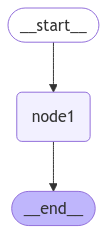

In [10]:
class State(TypedDict):
    x: Annotated[list[int], add]
        
def node1(state: State):
    print("---node 1---")
    return {'x': [state['x'][0] * 2]}

# Build graph
builder = StateGraph(State)
builder.add_node("node1", node1)

# Logic
builder.add_edge(START, "node1")
builder.add_edge("node1", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [11]:
graph.invoke({"x" : [1]})

---node 1---


{'x': [1, 2]}

Thus, the `operator.add` reducer function will append updates from each node to the list 'x'. 

This function may still cause an error if we give a number instead of a list

In [13]:
try:
    graph.invoke({"x": 1})
except TypeError as e:
    print(f"TypeError occured: {e}")

TypeError occured: can only concatenate list (not "int") to list


### Custom reducers

To prevent such error, we may define a [custom reducers](https://langchain-ai.github.io/langgraph/how-tos/subgraph/#custom-reducer-functions-to-manage-state). 

For example, lets define custom reducer logic to combine lists and handle cases where either or both of the inputs might be `None` or not a list.

In [16]:
from typing import Union
def reduce_list(left: Union[list, int, None], right: Union[list, int, None]) -> list:
    """Safely combine two lists, handling cases where either or both inputs might be int or None.

    Args:
        left (list | int | None): The first list to combine, or None.
        right (list | int | None): The second list to combine, or None.

    Returns:
        list: A new list containing all elements from both input lists.
               If an input is None, it's treated as an empty list.
    """
    if not left:
        left = []
    if not right:
        right = []
    if isinstance(left, int):
        left = [left]
    if isinstance(right, int):
        right = [right]
    return left + right

class CustomeReducerState(TypedDict):
    x: Annotated[list[int], reduce_list]

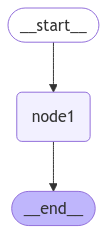

In [19]:
def node1(state: CustomeReducerState):
    print("---node 1---")
    return {'x': [state['x'][0] * 2]}

# Build graph
builder = StateGraph(CustomeReducerState)
builder.add_node("node1", node1)

# Logic
builder.add_edge(START, "node1")
builder.add_edge("node1", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [20]:
graph.invoke({'x': 3})

---node 1---


{'x': [3, 6]}

## Messages

In previous tutorials, we use the built-in reducer, `add_messages`, to handle messages in state.
* [`MessagesState`](https://langchain-ai.github.io/langgraph/concepts/low_level/#messagesstate) (a shortcut to work with messages) has a built-in `messages` key 
* It also has a built-in `add_messages` reducer for this key


In [22]:
from typing import Annotated
from langgraph.graph import MessagesState
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages

In [23]:
# Use MessagesState, which includes the messages key with add_messages reducer
class ExtendedMessagesState(MessagesState):
    # Add any keys needed beyond messages, which is pre-built 
    added_key_1: str
    added_key_2: str

Here, you see the application of `add_messages` reducer, which allows to append messages to `messages` key in our state.

In [24]:
from langgraph.graph.message import add_messages
from langchain_core.messages import AIMessage, HumanMessage

# Initial state
initial_messages = [AIMessage(content="Hello! How can I assist you?", name="Model"),
                    HumanMessage(content="I'm looking for information on marine biology.", name="Lance")
                   ]

# New message to add
new_message = AIMessage(content="Sure, I can help with that. What specifically are you interested in?", name="Model")

# Test
add_messages(initial_messages , new_message)

[AIMessage(content='Hello! How can I assist you?', additional_kwargs={}, response_metadata={}, name='Model', id='865bceed-ef38-4265-93a1-fc268ffc555f'),
 HumanMessage(content="I'm looking for information on marine biology.", additional_kwargs={}, response_metadata={}, name='Lance', id='f0acbf83-763d-4a8a-970f-469ea2a2bc7e'),
 AIMessage(content='Sure, I can help with that. What specifically are you interested in?', additional_kwargs={}, response_metadata={}, name='Model', id='44343a57-aead-46b4-833c-278de771bc06')]

### Re-writing

Let's show some useful tricks when working with the `add_messages` reducer.

If we pass a message with the same ID as an existing one in our `messages` list, it will get overwritten!

In [25]:
# Initial state
initial_messages = [AIMessage(content="Hello! How can I assist you?", name="Model", id="1"),
                    HumanMessage(content="I'm looking for information on marine biology.", name="Lance", id="2")
                   ]

# New message to add
new_message = HumanMessage(content="I'm looking for information on whales, specifically", name="Lance", id="2")

# Test
add_messages(initial_messages , new_message)

[AIMessage(content='Hello! How can I assist you?', additional_kwargs={}, response_metadata={}, name='Model', id='1'),
 HumanMessage(content="I'm looking for information on whales, specifically", additional_kwargs={}, response_metadata={}, name='Lance', id='2')]

### Removal

`add_messages` also enables [message removal](https://langchain-ai.github.io/langgraph/how-tos/memory/delete-messages/). For this:

1) use [RemoveMessage](https://api.python.langchain.com/en/latest/messages/langchain_core.messages.modifier.RemoveMessage.html) from `langchain_core` to isolate messages to delete.

**Parameter**
* id - The ID of the message to remove.

2) then we use `add_messages` to delete the isolated messages from the list.

In [26]:
from langchain_core.messages import RemoveMessage

# Message list
messages = [AIMessage("Hi.", name="Bot", id="1")]
messages.append(HumanMessage("Hi.", name="Lance", id="2"))
messages.append(AIMessage("So you said you were researching ocean mammals?", name="Bot", id="3"))
messages.append(HumanMessage("Yes, I know about whales. But what others should I learn about?", name="Lance", id="4"))

# Isolate messages to delete
delete_messages = [RemoveMessage(id=m.id) for m in messages[:-2]]
print(delete_messages)

[RemoveMessage(content='', additional_kwargs={}, response_metadata={}, id='1'), RemoveMessage(content='', additional_kwargs={}, response_metadata={}, id='2')]


In [27]:
add_messages(messages , delete_messages)

[AIMessage(content='So you said you were researching ocean mammals?', additional_kwargs={}, response_metadata={}, name='Bot', id='3'),
 HumanMessage(content='Yes, I know about whales. But what others should I learn about?', additional_kwargs={}, response_metadata={}, name='Lance', id='4')]

We can see that mesage IDs 1 and 2, as noted in `delete_messages` are removed by the reducer.